# SUPERVISED GRAPH CLASSIFICATION with GNN - PyTorch Geometric

Rebecca Casati

AI Models for Physics Exam

## Preliminary

In [ ]:
# Choose if saving the figures on Google Drive or not:
save_gdrive = False

In [ ]:
# Install required packages.
import os
import torch
import networkx as nx
os.environ['TORCH'] = torch.__version__

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 54.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
if save_gdrive:
  from google.colab import drive
  drive.mount('/content/drive')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Selected device:", device)

Selected device: cuda


## Dataset

 [**TUDatasets**](https://chrsmrrs.github.io/datasets/), in PyTorch Geometric: [`torch_geometric.datasets.TUDataset`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.TUDataset)

In [ ]:
from torch_geometric.datasets import TUDataset

dataset_str = 'MUTAG'
# dataset_str = 'Mutagenicity'
# dataset_str = 'MOLT-4'
dataset = TUDataset(root='data/TUDataset', name=dataset_str)

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features per node in the dataset: {dataset.num_features}')
print(f'Number of features per edge in the dataset: {dataset.num_edge_features}')
print(f'Number of classes: {dataset.num_classes}')

Processing...



Dataset: MUTAG(188):
Number of graphs: 188
Number of features per node in the dataset: 7
Number of features per edge in the dataset: 4
Number of classes: 2


Done!


Inspect one graph of the dataset:

In [ ]:
g = dataset[0]  # Get the first graph object.

print(g)
print('=============================================================')

# Gather some statistics about the graph
print(f'Number of nodes: {g.num_nodes}')
print(f'Number of edges: {g.num_edges}')
print(f'Average node degree: {g.num_edges / g.num_nodes:.2f}')
print(f'Has isolated nodes: {g.has_isolated_nodes()}')
print(f'Has self-loops: {g.has_self_loops()}')
print(f'Is undirected: {g.is_undirected()}')

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Print the graph (conversion to NetworkX):

Number of nodes: 17
Number of edges: 38
Graph feature:  {'y': [1]}
Node features:  [(0, {'x': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}), (1, {'x': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}), (2, {'x': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}), (3, {'x': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}), (4, {'x': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}), (5, {'x': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}), (6, {'x': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}), (7, {'x': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}), (8, {'x': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}), (9, {'x': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}), (10, {'x': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}), (11, {'x': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}), (12, {'x': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}), (13, {'x': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}), (14, {'x': [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]}), (15, {'x': [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]}), (16, {'x': [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]})]
Edge features:  [(0, 1, {'edge_attr': [1.0, 0.0, 0.0, 0.0]}), (0, 5, {'edge_

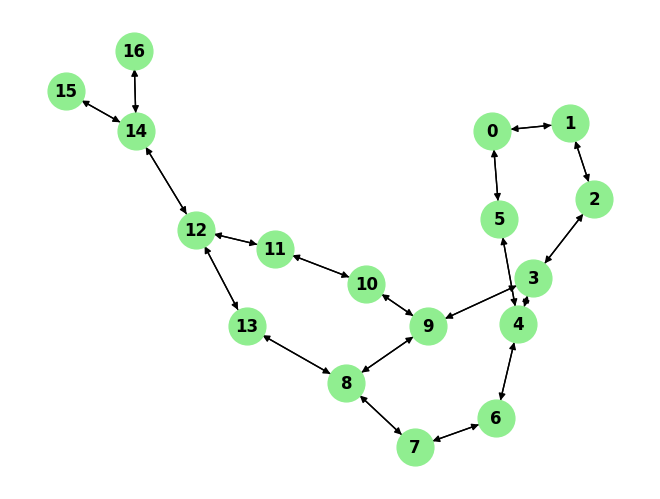

In [ ]:
from torch_geometric.utils import to_networkx

G = to_networkx(g, node_attrs = ["x"], edge_attrs = ["edge_attr"], graph_attrs= ["y"])
print(f'Number of nodes: {G.number_of_nodes()}')
print(f'Number of edges: {G.number_of_edges()}')
print("Graph feature: ", G.graph)
print("Node features: ", G.nodes.data())
print("Edge features: ", G.edges.data())
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=700, node_color='lightgreen')

## Training

### Mini-batching

Shuffle the dataset and divide it into training set and test set:

In [ ]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

# 80% training and 20% test
idx_train = int(0.8*len(dataset))
train_dataset = dataset[:idx_train]
test_dataset = dataset[idx_train:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


Batch the graphs:

In [ ]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2636], x=[1188, 7], edge_attr=[2636, 4], y=[64], batch=[1188], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2506], x=[1139, 7], edge_attr=[2506, 4], y=[64], batch=[1139], ptr=[65])

Step 3:
Number of graphs in the current batch: 22
DataBatch(edge_index=[2, 852], x=[387, 7], edge_attr=[852, 4], y=[22], batch=[387], ptr=[23])



Explore the dataloader:

In [ ]:
for data in train_loader:  # Iterate in batches over the training dataset.
    #print(type(data))
    print("data.x = ", data.x.shape[1])
    print("data.edge_index = ", data.edge_index.shape)
    #print("data.edge_attr = ", data.edge_attr.shape)
    print("data.batch = ", data.batch)
    print("data.y = ", data.y)
    #print("ptr = ", data.ptr)

data.x =  7
data.edge_index =  torch.Size([2, 2560])
data.batch =  tensor([ 0,  0,  0,  ..., 63, 63, 63])
data.y =  tensor([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
        0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1])
data.x =  7
data.edge_index =  torch.Size([2, 2454])
data.batch =  tensor([ 0,  0,  0,  ..., 63, 63, 63])
data.y =  tensor([0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0])
data.x =  7
data.edge_index =  torch.Size([2, 980])
data.batch =  tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
         3,  3,  3,  3,  3, 

### Model

Define the model (Convolutional layer: [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv)):

In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GNNpyg(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNNpyg, self).__init__()
        torch.manual_seed(12345)
        # 3 layers of the GNN
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        # final layer (MLP) after pooling to find the final result associated to a graph
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, data):
        # 1. Obtain node embeddings
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer (pooling to compress the information of each node of the graph)
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

model = GNNpyg(hidden_channels=64)
print(model)

GNNpyg(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


### Train and test

In [ ]:
import time

times = []
for i in range(11):
    print("RUN N. ", i)
    start_time = time.time()

    model = GNNpyg(hidden_channels=64)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    def train():
        model.train()
        total_loss = 0.0
        num_batches = 0
        for data in train_loader:  # Iterate in batches over the training dataset
            out = model(data.to(device))  # Perform a single forward pass
            loss = criterion(out, data.y.to(device))  # Compute the loss
            loss.backward()  # Compute gradients
            optimizer.step()  # Update parameters based on gradients
            optimizer.zero_grad()  # Clear gradients
            num_batches +=1
            loss = loss.to("cpu")
            total_loss += loss.detach()
        mean_loss = total_loss/num_batches
        return mean_loss

    def test(loader):
        model.eval()
        correct = 0
        for data in loader:  # Iterate in batches over the training/test dataset
            out = model(data.to(device))
            pred = out.argmax(dim=1)  # Use the class with highest probability
            correct += int((pred == data.y.to(device)).sum())  # Check against ground-truth labels
        return correct / len(loader.dataset)  # Derive ratio of correct predictions

    losses = []
    train_accs = []
    test_accs = []
    n_epochs = 170
    epochs = range(1, n_epochs+1)
    for epoch in epochs:
        loss = train()
        losses.append(loss)
        train_acc = test(train_loader)
        train_accs.append(train_acc)
        test_acc = test(test_loader)
        test_accs.append(test_acc)
        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

    end_time = time.time()
    total_time = end_time - start_time
    times.append(total_time)
    print(f"Time of execution: {total_time:.4f} seconds")

RUN N.  0
Epoch: 001, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 002, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 003, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 004, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 005, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 006, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 007, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 008, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 009, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 010, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 011, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 012, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 013, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 014, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 015, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 016, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 017, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 018, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 019, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 020, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 021, Train Acc: 0.6467,

## Results

Time of execution:

In [ ]:
import numpy as np

for i in range(1, len(times)):
  print(f"RUN N.{i}: Time of execution: {times[i]:.4f} seconds = {(times[i])/60:.4f} minutes")

times.pop(0)
time_mean = np.mean(np.array(times))
time_std = np.std(np.array(times))/np.sqrt(10)
print("MEAN TIME: ", time_mean)
print("STD TIME: ", time_std)

RUN N.1: Time of execution: 7.7921 seconds = 0.1299 minutes
RUN N.2: Time of execution: 8.0185 seconds = 0.1336 minutes
RUN N.3: Time of execution: 8.2838 seconds = 0.1381 minutes
RUN N.4: Time of execution: 7.4251 seconds = 0.1238 minutes
RUN N.5: Time of execution: 9.5076 seconds = 0.1585 minutes
RUN N.6: Time of execution: 8.5031 seconds = 0.1417 minutes
RUN N.7: Time of execution: 7.5195 seconds = 0.1253 minutes
RUN N.8: Time of execution: 8.3842 seconds = 0.1397 minutes
RUN N.9: Time of execution: 8.3822 seconds = 0.1397 minutes
RUN N.10: Time of execution: 7.5542 seconds = 0.1259 minutes
MEAN TIME:  8.137042546272278
STD TIME:  0.18751544003952147


Plot the accuracies:

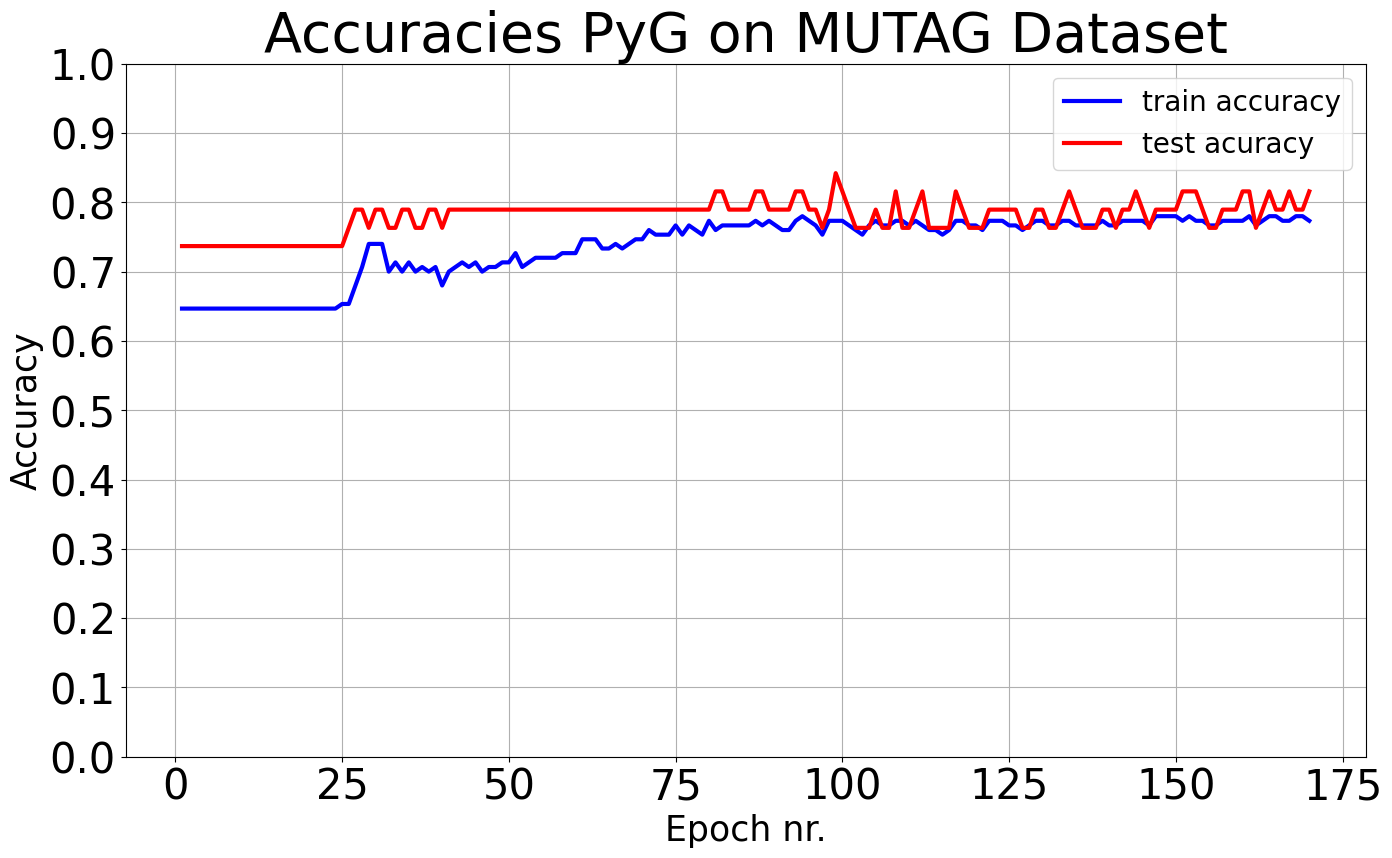

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig1 = plt.figure(figsize = (16,9))
plt.plot(epochs, train_accs, color = "blue", label = "train accuracy", lw = 3)
plt.plot(epochs, test_accs, color = "red", label = "test acuracy", lw = 3)
plt.xlabel("Epoch nr.", fontsize = 25)
plt.ylabel("Accuracy", fontsize = 25)
plt.xticks(fontsize = 30)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize = 30)
plt.legend(fontsize = 20)
plt.grid()
plt.title("Accuracies PyG on " + dataset_str + " Dataset", fontsize = 40)
if not save_gdrive:
  plt.savefig("Accuracies.png")
else:
  plt.savefig("/content/drive/My Drive/AIM4P_Project_GNN/Accuracies_PyG_" + dataset_str)

plt.show()

Plot the loss:

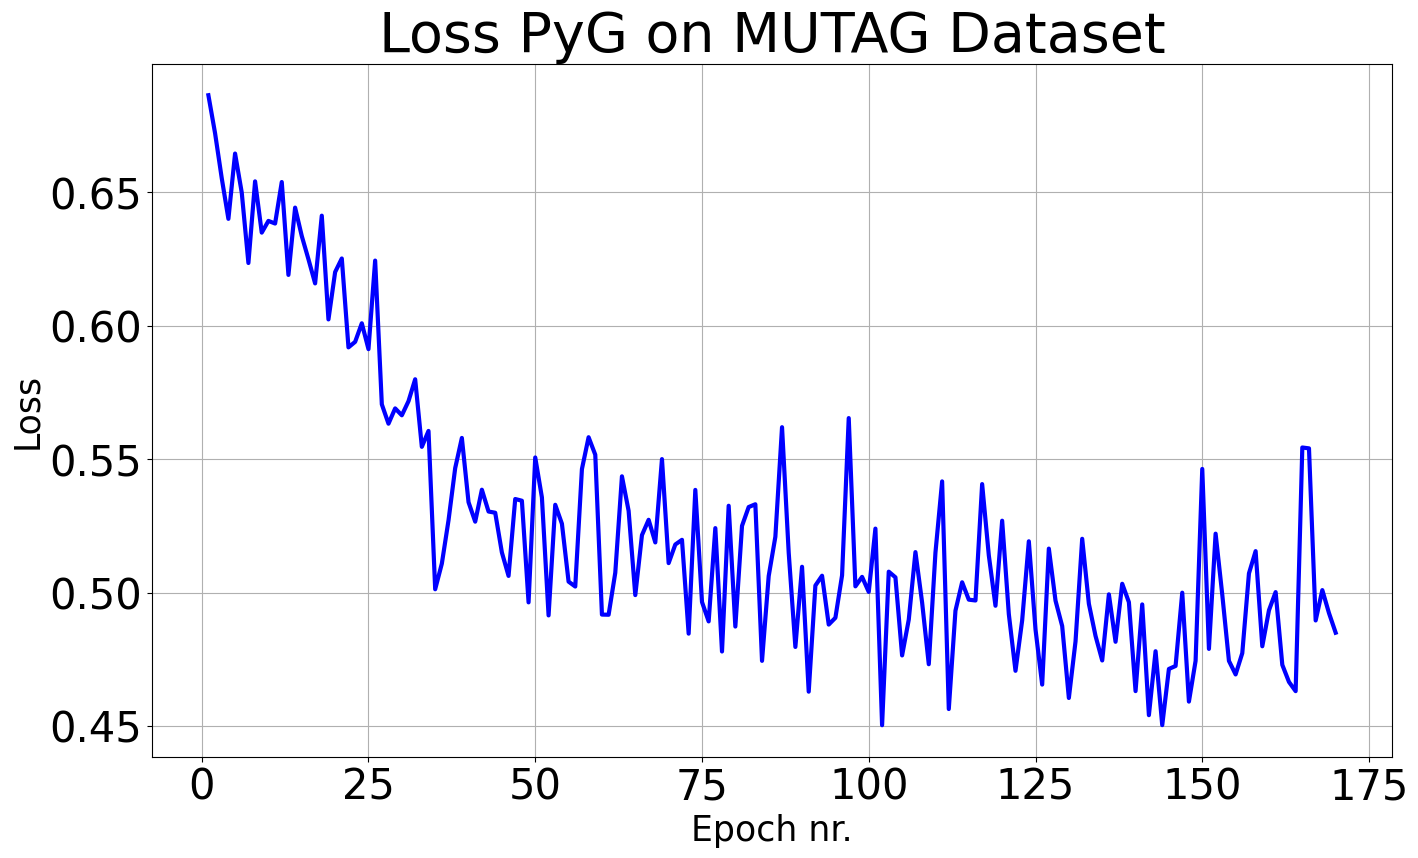

In [ ]:
fig2 = plt.figure(figsize = (16,9))
plt.plot(epochs, losses, color = "blue", lw = 3)
plt.xlabel("Epoch nr.", fontsize = 25)
plt.ylabel("Loss", fontsize = 25)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid()
plt.title("Loss PyG on " + dataset_str + " Dataset", fontsize = 40)
if not save_gdrive:
    plt.savefig("Loss.png")
else:
  plt.savefig("/content/drive/My Drive/AIM4P_Project_GNN/Loss_PyG_" + dataset_str)
plt.show()